## Library

In [1]:
# ====================================================
# Library
# ====================================================
import os
import copy
import cv2
cv2.setNumThreads(0) 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18


import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'working with {device}')


working with cuda


## Grad-CAM on Imagenet using a Resnet18 CNN and a Hook class

### Dataset class

In [2]:
# use the ImageNet transformation
def get_transforms():
    return A.Compose([            
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])


class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform=None):
        
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)
        
    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        
        imgpath = os.path.join(self.main_dir, self.all_imgs[idx])
        
        image = cv2.imread(imgpath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:        
            augmented = self.transform(image=image)
            image = augmented['image']
            
        return image, imgpath


### Model

In [3]:
class RESNET(nn.Module):
    def __init__(self):
        super(RESNET, self).__init__() 
        self.resnet = resnet18(pretrained=True)
                
    def forward(self, x):        
        x = self.resnet(x)
        return x

In [4]:
model = RESNET()

In [5]:
# We can print the names of the model to get the name of a specific layer we are interested in.
for name, layer in model.named_modules():
    print(name)


resnet
resnet.conv1
resnet.bn1
resnet.relu
resnet.maxpool
resnet.layer1
resnet.layer1.0
resnet.layer1.0.conv1
resnet.layer1.0.bn1
resnet.layer1.0.relu
resnet.layer1.0.conv2
resnet.layer1.0.bn2
resnet.layer1.1
resnet.layer1.1.conv1
resnet.layer1.1.bn1
resnet.layer1.1.relu
resnet.layer1.1.conv2
resnet.layer1.1.bn2
resnet.layer2
resnet.layer2.0
resnet.layer2.0.conv1
resnet.layer2.0.bn1
resnet.layer2.0.relu
resnet.layer2.0.conv2
resnet.layer2.0.bn2
resnet.layer2.0.downsample
resnet.layer2.0.downsample.0
resnet.layer2.0.downsample.1
resnet.layer2.1
resnet.layer2.1.conv1
resnet.layer2.1.bn1
resnet.layer2.1.relu
resnet.layer2.1.conv2
resnet.layer2.1.bn2
resnet.layer3
resnet.layer3.0
resnet.layer3.0.conv1
resnet.layer3.0.bn1
resnet.layer3.0.relu
resnet.layer3.0.conv2
resnet.layer3.0.bn2
resnet.layer3.0.downsample
resnet.layer3.0.downsample.0
resnet.layer3.0.downsample.1
resnet.layer3.1
resnet.layer3.1.conv1
resnet.layer3.1.bn1
resnet.layer3.1.relu
resnet.layer3.1.conv2
resnet.layer3.1.bn2
res

### Hook class

In [6]:
# A hook class that returns the input and output of a layer during forward/backward pass
# I got inspired by the Kaggle Notebook by Sirong Huang that I recommend:
# https://www.kaggle.com/sironghuang/understanding-pytorch-hooks
class Hook():
    def __init__(self, name, module, backward=False):
        
        self.name = name 
        
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    
    def close(self):
        self.hook.remove()


In [7]:
# Here we are saving all hooks for all layers into two lists, one for forward hooks and one for backwards hooks.
# Every hook is capable to register both the input and the output (see the above class).
# Note the different directions of the flow.
# For Forward hooks the feature maps flow rightwise:  input ----> layer ----> output
# For Backward hooks the gradients flow leftwise: output <----- layer ----- input

hookF = [Hook(name, layer) for name, layer in model.named_modules()]
hookB = [Hook(name, layer,backward=True) for name, layer in model.named_modules()]

### Dataset and Dataloader

In [8]:
dataset = CustomDataSet("/home/nico/Desktop/data/", transform=get_transforms())

dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=1, 
                        drop_last=False, pin_memory=False)

### Let's go: forward and backward pass of a random image

In [9]:
# Get only one random image
for idx, (img, imgpath) in enumerate(dataloader):
    if idx==1: break

model.eval()    

imgpath = imgpath[0] # Note sure why imgpath is a tuple
print(imgpath)

# Forward pass
pred = model(img)

# Get the predicted label
label = pred.argmax().item()
print(f'Predicted label: {label}')

# Backprop from the correct label
pred[:, label].backward()

/home/nico/Desktop/data/shark.jpeg
Predicted label: 2


/home/nico/anaconda3/envs/Icelearning/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


### Extract activation and gradients of the layer we want and calculate Grad-CAM heatmap

*********  Forward and Backward Hooks extraction  *********
Foward hooks:
output of resnet.layer4.1.conv2
torch.Size([1, 512, 7, 7])
--------------------
Backward hooks:
gradient of resnet.layer4.1.conv2
torch.Size([1, 512, 7, 7])
--------------------
GAP gradients shape: torch.Size([512])
Heatmap shape: torch.Size([7, 7])


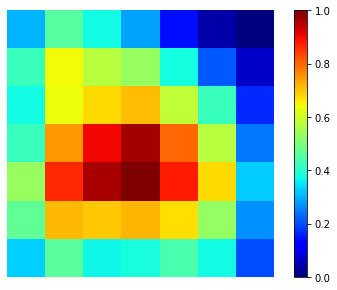

In [10]:
act, grad = None, None

# Loop over hook lists hookF, hookB and extract the activation and gradient of the resnet.layer4.1.conv2 layer
print('***'*3+'  Forward and Backward Hooks extraction  '+'***'*3)
for hook in hookF:
    if hook.name == 'resnet.layer4.1.conv2':
        act = hook.output.detach()
        print('Foward hooks:')
        print('output of', hook.name)
        print(act.shape)
        print('-'*20)

for hook in hookB:
    if hook.name == 'resnet.layer4.1.conv2':
        print('Backward hooks:')
        grad = hook.output[0].detach()
        print('gradient of', hook.name)
        print(grad.shape)
        print('-'*20)
        

# Global Average Pool the gradients of every feature map (Eq. 1)
pooled_grad = torch.mean(grad, dim=[0, 2, 3])
print('GAP gradients shape:', pooled_grad.shape)

# Multiply every channel k of the activations by GAP gradients, that are the 'weights'
for i in range(act.shape[1]):
    act[:, i, :, :] *= pooled_grad[i]

# Sum across all k-features (Eq. 2)
heatmap = torch.sum(act, dim=1).squeeze()

# Relu (Eq. 2)
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap between 0 and 1
heatmap /= torch.max(heatmap)
print('Heatmap shape:', heatmap.shape)

# Visualize the raw CAM
plt.imshow(heatmap.numpy(), cmap='jet'); plt.axis('off'); plt.tight_layout(); plt.colorbar(); plt.show()

### Let's see the result of the Grad-CAM on the image we have classified

Image shape (423, 500, 3). Heatmap shape (423, 500)


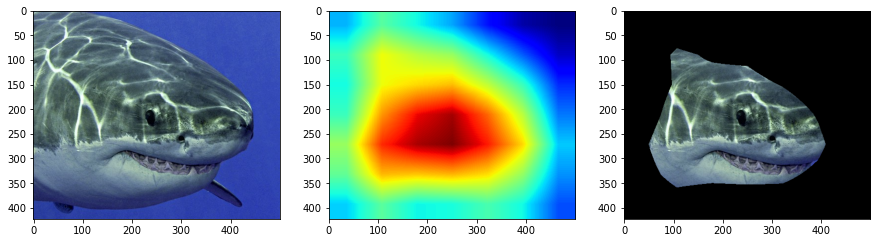

In [11]:
img_jpeg = cv2.imread(imgpath)
img_jpeg = cv2.cvtColor(img_jpeg, cv2.COLOR_BGR2RGB)
H, W = img_jpeg.shape[0], img_jpeg.shape[1]

heatmap = cv2.resize(np.array(heatmap), (W, H))
print(f'Image shape {img_jpeg.shape}. Heatmap shape {heatmap.shape}')

mask = heatmap>0.6 # let us see where heatmap is above some threshold

superimposed_img = img_jpeg.copy()
superimposed_img[:,:,0] = img_jpeg[:,:,0]*mask
superimposed_img[:,:,1] = img_jpeg[:,:,1]*mask
superimposed_img[:,:,2] = img_jpeg[:,:,2]*mask

fig, axs = plt.subplots(1,3, figsize=(15,5))
img1 = axs[0].imshow(img_jpeg)
img2 = axs[1].imshow(heatmap, cmap='jet')
img3 = axs[2].imshow(superimposed_img)

plt.show()

### Alternative to the Hook class

#### A popular alternative to the Hook class 

In [12]:
instead_of_hook_class = False

if instead_of_hook_class is True:
    
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output
        return hook

    gradients = {}
    def get_gradient(name):
        def hook(model, input, output):
            gradients[name] = output
        return hook
    
    # First populate the two dictionaries
    # For e.g. we may be only interested to register the following layer
    for name, layer in model.named_modules():
        print(name)
        if name == 'resnet.layer4.1.conv2':
            layer.register_forward_hook(get_activation(name))
            layer.register_backward_hook(get_gradient(name))

    # After the forward and backward pass of the model are done we retrieve the activation and the gradient: 
    # Activation
    act = activations['resnet.layer4.1.conv2'].detach()
    print('Activation shape:', act.shape)

    # Gradient
    grad = gradients['resnet.layer4.1.conv2'][0].detach()
    print('Gradients shape:', grad.shape)